In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from math import radians as rad
from math import degrees as deg

from datetime import timedelta
import xarray as xr

In [2]:
## Compute solar geometry..
# https://gml.noaa.gov/grad/solcalc/solareqns.PDF

In [14]:
## THIS PART IS FOR CALCULATING SOLAR NOON --- WE ULTIAMTELY JUST WANT THE #OF HOURS 
## THAT ARE +/- SOLAR NOON FOR A GIVEN DATETIME ... FOR NOW WE JUST ASSUME THAT 
## 12 IS THE SOLAR NOON
def eqtime(da):
    # Literally called "equation of time"   -- Minutes 
    #---------------------------------------
    ### equation of time - an astronomical term accounting for changes in the time of solar noon 
    ### for a given location over the course of a year. Earth's elliptical orbit and Kepler's law of 
    ### equal areas in equal times are the culprits behind this phenomenon. 
    ### Click here to see a plot of the equation of time vs. day of the year. 
    ### For more information on this phenomenon, see this offsite Analemma page.
    ### https://gml.noaa.gov/grad/solcalc/glossary.html#equationoftime
    #---------------------------------------
    eqt = 229.18*(0.000075 + 0.001868*np.cos(da) - 0.032077*np.sin(da) - 0.014615*np.cos(2*da) - 0.040849*np.sin(2*da))
    return eqt

In [15]:
def day_angle(doy):
    # doy is julian day
    return 2 * np.pi * (doy-1)/365  # RADIANS


In [16]:
def eccentricity(da):
    # da is the day_angle (radians)
    e = 1.000110 + 0.034221 * np.cos(da) + .001280*np.sin(da) + .000719*np.cos(2*da) + .000077*np.sin(2*da)
    return e

In [17]:
def declination(da):
    # da is the day angle
    d = .006918 - 0.399912*np.cos(da) + 0.070257*np.sin(da) - 0.006758*np.cos(2*da) # RADIANS
    return d

In [18]:
def zenith_angle(lat, dec, wt):
    # lat is latitude (radians)
    # dec is teh declination (radians)
    # w is the angular velocity of the earths rotation
    # t is the number of hours before/after solar noon
    
    # w is always the same...

    # w = .2618 # rad/hr == 15deg/hr

    # compute first part...
    cza = np.sin(lat)*np.sin(dec) + np.cos(lat)*np.cos(dec)*np.cos(wt)
    
    # take the inverse 
    return cza

In [19]:
def tr_ts(lat, dec):
    # return the sunrise and sunset times...
    w = .2618 # this is constant... earths rotation in radians
    Ts = np.arccos(-np.tan(dec)*np.tan(lat))/w  # time sunset
    Tr = -Ts # always symmetrical ...           # time sunrise
    return Ts, Tr

In [20]:
def equiv_hz_sfc(ks, h, lat):
    # this is the latitude of the "equivalent horizontal surface"
    # ks is the slope inclination
    # h is the slope azimuth
    # lat is the latitude
    return np.arcsin(np.sin(ks)*np.cos(h)*np.cos(lat) + np.cos(ks)*np.sin(lat))

def a_long_diff(ks,h,lat):
    # difference in longitude between equivalent horizontal surface and slope
    return np.arctan(np.sin(h)*np.sin(ks)/(np.cos(ks)*np.cos(lat)-np.cos(h)*np.sin(ks)*np.sin(lat)))

In [148]:
## Plot the irradiance
def irrad(lat,
          long,
          ks,
          h,
          date):

    #lat:  lat in radians
    #long: long in radians
    #ks:   slope inclination in radians
    #h:    slope azimuth, radians clockwise from North (0 is North)
    #date: date (timesampt object)
    #t   : hour relative to solar noon (this will be updated later)
    
    solar_const = 1364. #w/m2 
    w = .2618           # rad/hr == 15deg/hr

    # get the hour
    hour = date.hour # this is 0-24
    t = hour - 12
    
    # begin geometru calculations
    da = day_angle(date.dayofyear)
    ec = eccentricity(da)
    dec = declination(da)
    sunrise, sunset = tr_ts(lat, dec)   
    # do the adjustment for slopes
    eqhz = equiv_hz_sfc(ks, h, lat)
    a = equiv_hz_sfc(ks, h, lat)
    wta = w*t+a
    
    # compute the zentith angle
    cza = zenith_angle(lat, dec, wta)

    # now compute the irradiation
    ket = solar_const * ec * cza  #cza is the cosine of the zenith angle
    
    return ket.where(ket>0)

In [149]:
### Equivalent slope stuff...
### This is so that we can compute the 
### radiaion on hill slopes

In [150]:
##example... 
days_in_year = 365
timezone = -7 # relative to GMT
lat = rad(55)
long = rad(-116.5)
slope = rad(30)    # 30 Degree slope..
azimuth = rad(145) # Clockwise from North(0)

# check answer with book...
#deg(equiv_hz_sfc(slope, azimuth, rad(lat)))

# now do a...
#deg(a_long_diff(slope, azimuth, rad(lat)))

In [151]:
irrad(lat, long, slope, azimuth, dr[10])

AttributeError: 'numpy.float64' object has no attribute 'where'

In [152]:
### LOAD UP A MAP

In [153]:
aspect =  xr.open_dataset("500m_ModelRuns/aspect_regrid_500m.nc")
slope = xr.open_dataset("500m_ModelRuns/slope_regrid_500m.nc")

In [154]:
slope = slope.rename(dict(__xarray_dataarray_variable__="slope"))
aspect = aspect.rename(dict(__xarray_dataarray_variable__="aspect"))

In [182]:
dr = pd.date_range("2017-01-01 12:00", "2018-01-01 12:00", freq="h")

In [219]:
d1e = pd.to_datetime("2018-03-21 03:00")
d2e = pd.to_datetime("2018-03-21 12:00")
d3e = pd.to_datetime("2018-03-21 17:00")

In [220]:
lat = slope.lat*np.pi/180
lon = slope.lon*np.pi/180
slope_rad = slope.slope*np.pi/180
aspect_rad = aspect.aspect*np.pi/180

In [221]:
#swnorm = [irrad(lat, lon, slope_rad, aspect_rad, d) for d in dr]
may31_6am_rad = irrad(lat, lon, slope_rad, aspect_rad, d1e)
may31_12am_rad = irrad(lat, lon, slope_rad, aspect_rad, d2e)
may31_6pm_rad = irrad(lat, lon, slope_rad, aspect_rad, d3e)

In [222]:
mask=xr.open_dataset("./ASOdata/geo_em_with_EastMask.nc")

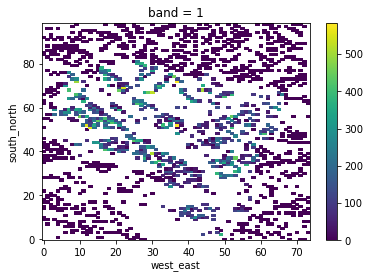

In [223]:
(may31_6am_rad*mask.EAST_MASK.isel(Time=0)).plot()

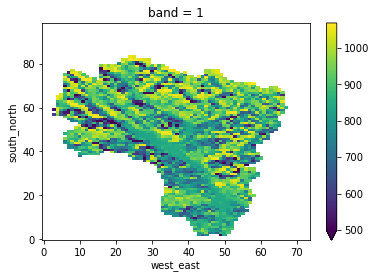

In [227]:
(may31_12am_rad.where(mask.EAST_MASK.isel(Time=0) != 0)).plot(vmin=500)

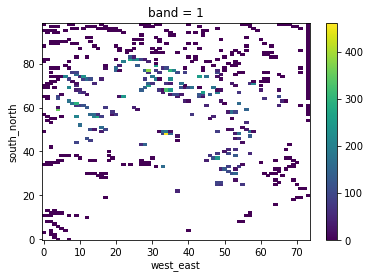

In [213]:
(may31_6pm_rad*mask.EAST_MASK.isel(Time=0)).plot()


In [139]:
swcat = xr.concat(swnorm, dim="band")

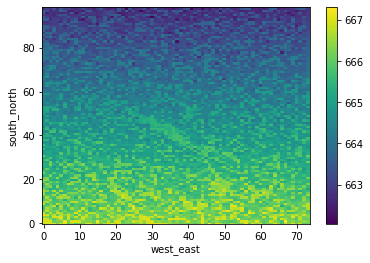

In [140]:
swcat.where(swcat>0).mean(dim="band").plot()

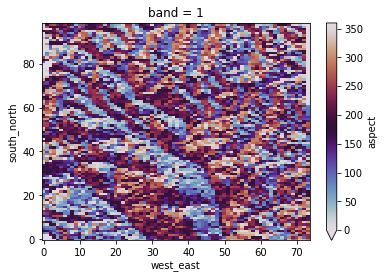

In [130]:
aspect.aspect.plot(vmin=0, vmax=360, cmap="twilight")

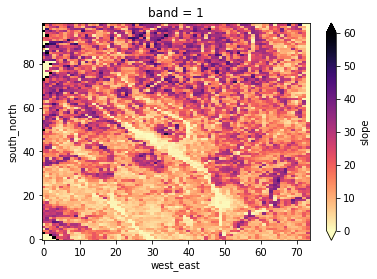

In [135]:
slope.slope.plot(vmin=0,vmax=60,cmap='magma_r')